# Molecular Data Analysis: Free-Wilson & Molecule Networks

This notebook demonstrates an integrated workflow for Free‑Wilson analysis, R‑group decomposition, and molecular networking. It includes:

- **Display of the core(s)** found by the R‑group decomposition using *mols2grid*.
- **Model predictions visualization:** A Ridge regression model is trained using one‑hot encoded R‑groups and its predictions are compared to experimental pIC50 values.
- Interactive network visualizations of both regression coefficients and original molecules using *PyVis*.

**Note:** This notebook is a standalone Python notebook (without Streamlit) and is organized into separate cells for clarity.

In [10]:
# Imports and Setup
import pandas as pd
import numpy as np
import io, base64
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.cm as cm  

from rdkit import Chem
from rdkit.Chem import Draw, AllChem, DataStructs
from rdkit.Chem.rdRGroupDecomposition import RGroupDecompose
from rdkit.Chem.TemplateAlign import AlignMolToTemplate2D

from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

# For model prediction visualization
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# For displaying molecule grids
import mols2grid

# For PyVis network visualization
from pyvis.network import Network
from IPython.core.display import display, HTML


/var/folders/w_/fk4f1zsd0yv83v2w5hzgfv2c0000gn/T/ipykernel_92574/700581432.py:28: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [11]:
# Helper Functions
def generate_molecule_image(mol, size=(300,300)):
    """Generate a base64-encoded PNG image of the molecule."""
    if mol is None:
        return ""
    img = Draw.MolToImage(mol, size=size)
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

def get_color(score):
    """Return a discrete color: green if coefficient > 0, red if < 0, grey otherwise."""
    if score > 0:
        return "green"
    elif score < 0:
        return "red"
    else:
        return "grey"


## Data Source Selection

In this cell we load the dataset. For demonstration, we use an example dataset located at `data/CHEMBL313_sel.smi`. If you have your own CSV file, modify the code accordingly.

In [12]:
# Data Source Selection
try:
    fw_df = pd.read_csv("data/CHEMBL313_sel.smi")
except Exception as e:
    print(f"Failed to load dataset: {e}")

print("Dataset preview:")
print(fw_df.head())

Dataset preview:
                                       SMILES          Name  pIC50
0       Cc1ccc(C2CC3CCC(C2C(=O)OC(C)C)N3C)cc1  CHEMBL321806   5.99
1    Cc1ccc(C2CC3CCC(C2C(=O)Oc2ccccc2)N3C)cc1  CHEMBL340912   5.81
2  CN1C2CCC1C(C(=O)Oc1ccccc1)C(c1ccc(I)cc1)C2  CHEMBL340761   7.29
3       CC(C)OC(=O)C1C(c2ccc(I)cc2)CC2CCC1N2C  CHEMBL127546   7.90
4          COC(=O)C1C(c2ccc(Br)cc2)CC2CCC1N2C   CHEMBL97887   8.31


## Molecule Preparation and R-Group Decomposition

We convert the SMILES strings to RDKit Mol objects, align them to a core molecule, and perform R‑group decomposition.

In [13]:
# Molecule Preparation
fw_df['mol'] = fw_df.SMILES.apply(Chem.MolFromSmiles)
print("Molecule conversion complete. (Displaying SMILES only)")
print(fw_df[['SMILES']].head())

# Define the core molecule
core_smiles = "c1ccc(C2CC3CCC(C2)N3)cc1"
core_mol = Chem.MolFromSmiles(core_smiles)
if core_mol is None:
    raise ValueError("Error: Core molecule could not be parsed.")
if core_mol.GetNumConformers() == 0:
    AllChem.Compute2DCoords(core_mol)
print("Core molecule SMILES:", core_smiles)

# Align molecules to the core
aligned_mols = []
for mol in fw_df['mol']:
    if mol is not None:
        mol_copy = Chem.Mol(mol)
        if mol_copy.GetNumConformers() == 0:
            AllChem.Compute2DCoords(mol_copy)
        try:
            AlignMolToTemplate2D(mol_copy, core_mol)
        except Exception as e:
            print(f"Alignment failed for one molecule: {e}")
        aligned_mols.append(mol_copy)
    else:
        aligned_mols.append(None)
fw_df['aligned_mol'] = aligned_mols

# Perform R-group decomposition
rgroups, unmatched = RGroupDecompose(core_mol, list(fw_df['aligned_mol']), asSmiles=True)
rgroup_df = pd.DataFrame(rgroups)
print("R-group decomposition result (first 5 rows):")
print(rgroup_df.drop(columns=["Core"], errors="ignore").head())

# Summary of unique R groups (excluding 'Core')
unique_list = []
print("Unique R groups summary:")
for r in rgroup_df.columns:
    if r == "Core":
        continue
    num_rgroups = len(rgroup_df[r].unique())
    print(f"- {r}: {num_rgroups} unique groups")
    unique_list.append(list(rgroup_df[r].unique()))

Molecule conversion complete. (Displaying SMILES only)
                                       SMILES
0       Cc1ccc(C2CC3CCC(C2C(=O)OC(C)C)N3C)cc1
1    Cc1ccc(C2CC3CCC(C2C(=O)Oc2ccccc2)N3C)cc1
2  CN1C2CCC1C(C(=O)Oc1ccccc1)C(c1ccc(I)cc1)C2
3       CC(C)OC(=O)C1C(c2ccc(I)cc2)CC2CCC1N2C
4          COC(=O)C1C(c2ccc(Br)cc2)CC2CCC1N2C
Core molecule SMILES: c1ccc(C2CC3CCC(C2)N3)cc1
R-group decomposition result (first 5 rows):
         R1      R2                   R3        R4       R5
0  [H][*:1]  C[*:2]     CC(C)OC(=O)[*:3]  [H][*:4]   C[*:5]
1  [H][*:1]  C[*:2]  O=C(Oc1ccccc1)[*:3]  [H][*:4]   C[*:5]
2  [H][*:1]  C[*:2]  O=C(Oc1ccccc1)[*:3]  [H][*:4]   I[*:5]
3  [H][*:1]  C[*:2]     CC(C)OC(=O)[*:3]  [H][*:4]   I[*:5]
4  [H][*:1]  C[*:2]         COC(=O)[*:3]  [H][*:4]  Br[*:5]
Unique R groups summary:
- R1: 8 unique groups
- R2: 15 unique groups
- R3: 18 unique groups
- R4: 2 unique groups
- R5: 31 unique groups


## Display Core(s) Found by R-Group Decomposition

We now display the core(s) extracted from the R‑group decomposition using *mols2grid*.

In [14]:
# Display cores using mols2grid
core_df = pd.DataFrame({"mol": [Chem.MolFromSmiles(x) for x in rgroup_df.Core.unique()]})
mols2grid.display(core_df, size=(300,200), mol_col="mol")

MolGridWidget()

## Regression Model Preparation and Training

We encode the R‑group data using a one‑hot encoder, train a Ridge regression model to predict pIC50, and display the regression coefficients.

In [15]:
# Encode R-groups and train Ridge regression
if len(unique_list) == 0:
    raise ValueError("No R groups found. Check your input data and core molecule definition.")
else:
    enc = OneHotEncoder(categories=unique_list, sparse_output=False)
    rgroup_columns = [col for col in rgroup_df.columns if col != "Core"]
    one_hot_mat = enc.fit_transform(rgroup_df[rgroup_columns].values)

ridge = Ridge()
if "pIC50" not in fw_df.columns:
    raise ValueError("The dataset does not contain a 'pIC50' column. Check your dataset.")
else:
    ridge.fit(one_hot_mat, fw_df.pIC50)
    print("Ridge regression model trained successfully!")
    print("Model Intercept:", ridge.intercept_)
    rg_df_dict = {}
    start = 0
    for col, cat in zip(rgroup_columns, enc.categories_):
        coef_list = ridge.coef_[start:start+len(cat)]
        start += len(cat)
        rg_df = pd.DataFrame({"smiles": cat, "coef": coef_list})
        rg_df.sort_values("coef", inplace=True)
        rg_df_dict[col] = rg_df
    print("Regression coefficients for R groups:")
    for key, value in rg_df_dict.items():
        print(f"R group {key}:")
        print(value[['smiles','coef']])

Ridge regression model trained successfully!
Model Intercept: 7.3458821581803635
Regression coefficients for R groups:
R group R1:
            smiles      coef
6           F[*:1] -0.495891
7           C[*:1] -0.141241
4   c1cc([*:1])cs1 -0.105327
5          Cl[*:1] -0.021419
2   c1coc([*:1])c1  0.044673
0         [H][*:1]  0.068713
3  c1ccc([*:1])cc1  0.079673
1           I[*:1]  0.570820
R group R2:
                     smiles      coef
3                 FCCC[*:2] -0.593929
8               FC(F)C[*:2] -0.357950
4              I/C=C/C[*:2] -0.348413
6                 ICCC[*:2] -0.342950
5   O[C@H]1CCCC[C@@H]1[*:2] -0.309461
13         CN(C)C(=O)C[*:2] -0.272950
9                 OCCC[*:2] -0.067950
11            COC(C[*:2])OC  0.017050
7               C1CC1C[*:2]  0.077050
2                  FCC[*:2]  0.116140
0                    C[*:2]  0.159011
12            COC(=O)C[*:2]  0.177050
14               BrCCC[*:2]  0.362050
10               ClCCC[*:2]  0.377050
1                  [H][*:2

## Visualize Model Predictions

We split the data into training and test sets, train a Ridge regression model, make predictions, and visualize the model performance using an lmplot (with the R² value annotated).

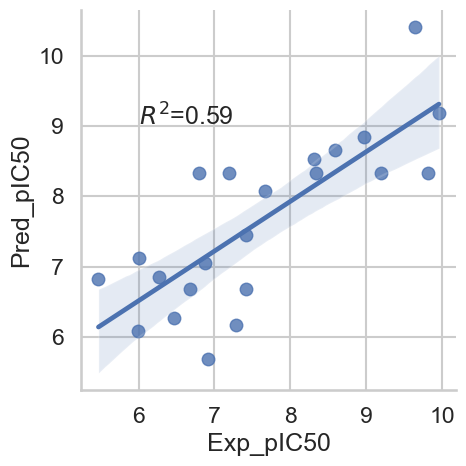

In [16]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Re-encode R-groups (using all columns except the first)
enc2 = OneHotEncoder(categories=unique_list, sparse_output=False)
one_hot_mat2 = enc2.fit_transform(rgroup_df.values[:,1:])

# Split the data into training and test sets
train_X, test_X, train_y, test_y = train_test_split(one_hot_mat2, fw_df.pIC50, test_size=0.2, random_state=42)

# Train Ridge regression model
ridge2 = Ridge()
ridge2.fit(train_X, train_y)
pred = ridge2.predict(test_X)

# Visualize model performance
sns.set(rc={'figure.figsize': (10, 10)})
sns.set_style('whitegrid')
sns.set_context('talk')
res_df = pd.DataFrame({'Exp_pIC50': test_y, 'Pred_pIC50': pred})
r2 = r2_score(test_y, pred)
fgrid = sns.lmplot(x='Exp_pIC50', y='Pred_pIC50', data=res_df)
ax = fgrid.axes[0, 0]
ax.text(6, 9, f"$R^2$={r2:.2f}")
plt.show()

## Network Visualization (Regression Coefficients)

We build an interactive network of the regression coefficients using PyVis. Each R‑group fragment node is colored discretely (green for positive, red for negative).

[16:34:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:34:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:34:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:34:09] WARNING: not removing hydrogen atom with dummy atom neighbors
[16:34:09] WARNING: not removing hydrogen atom with dummy atom neighbors


free_wilson_coefficient_network.html



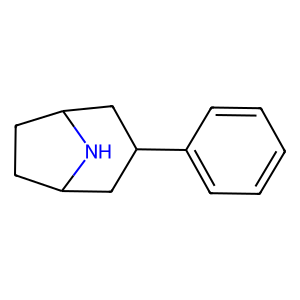
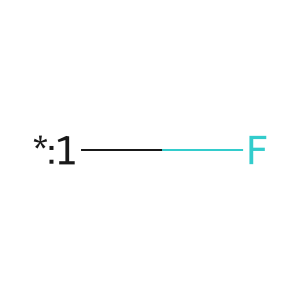
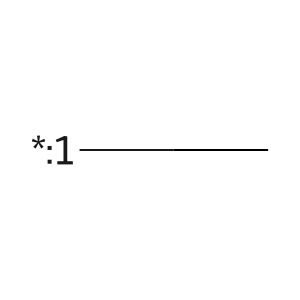
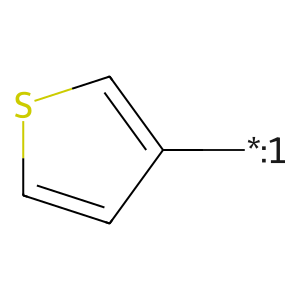
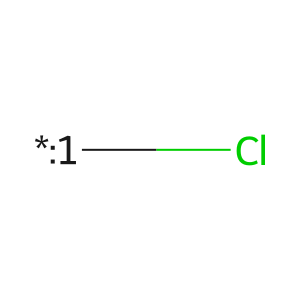
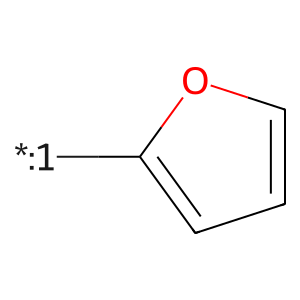
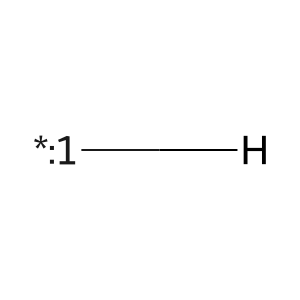
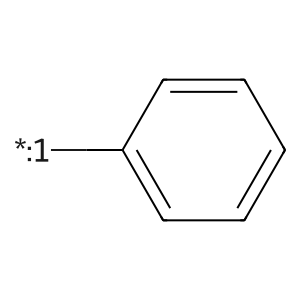
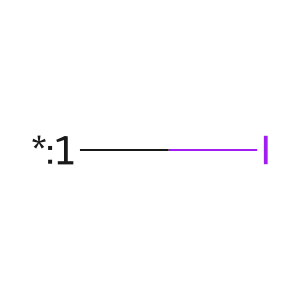
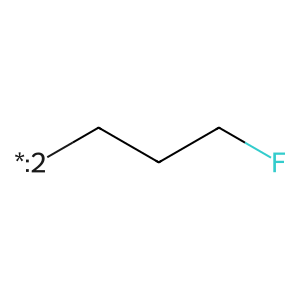
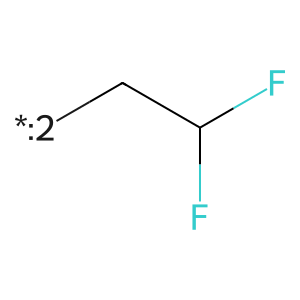
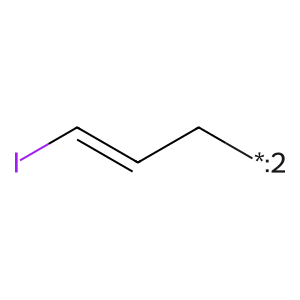
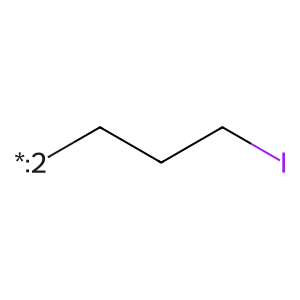
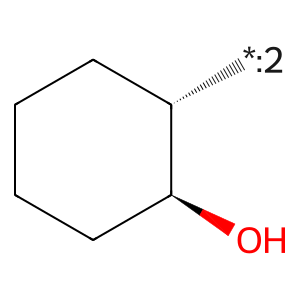
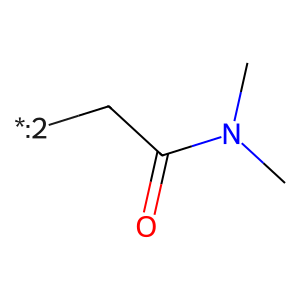
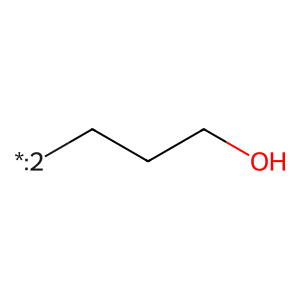
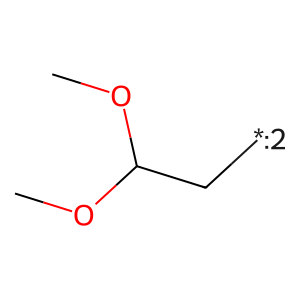
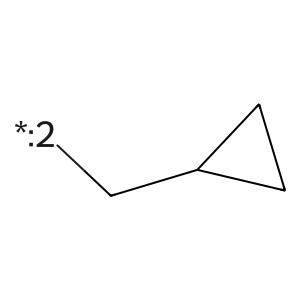
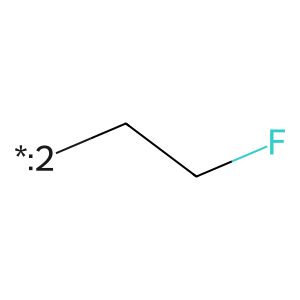
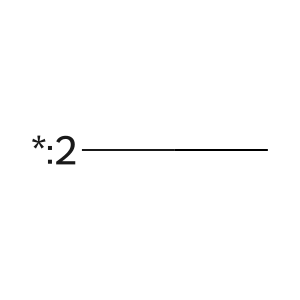
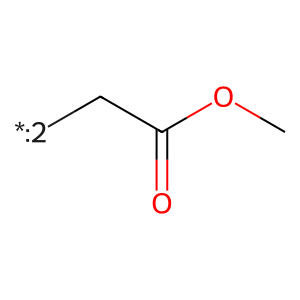
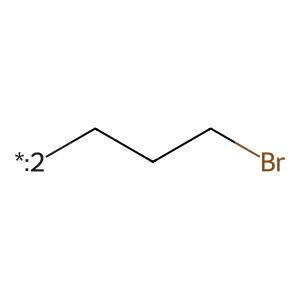
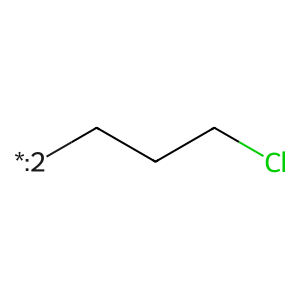
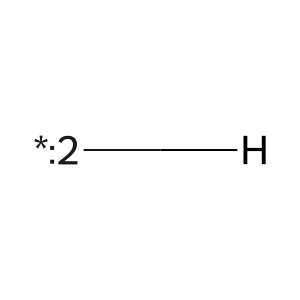
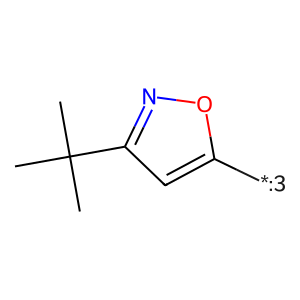
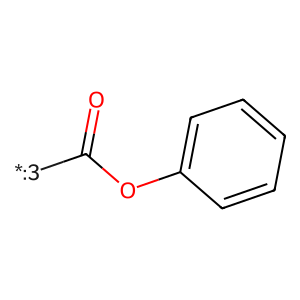
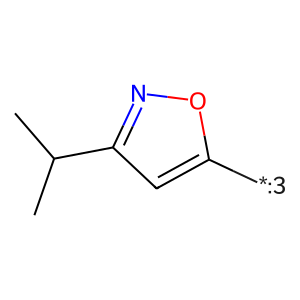
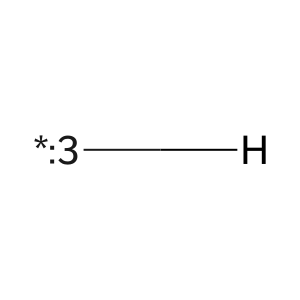
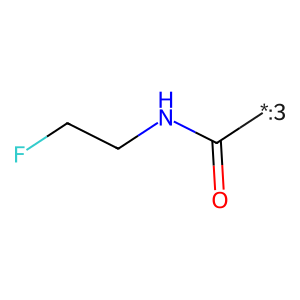
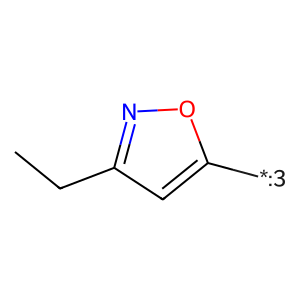
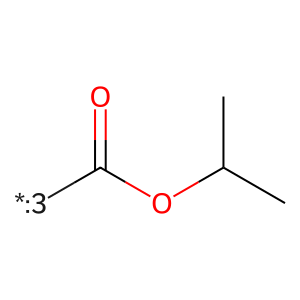
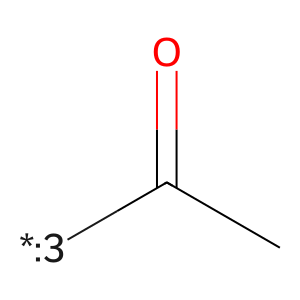
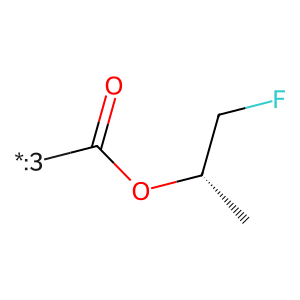
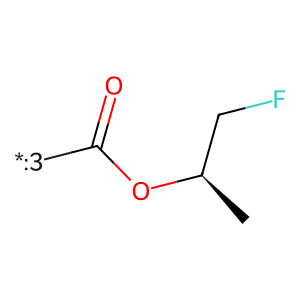
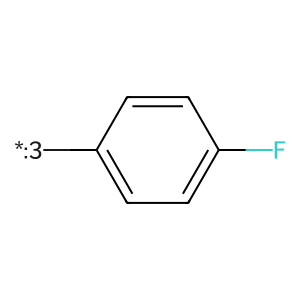
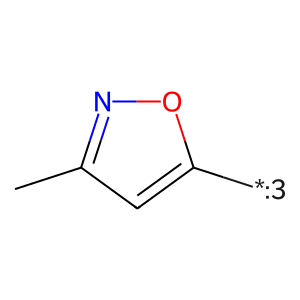
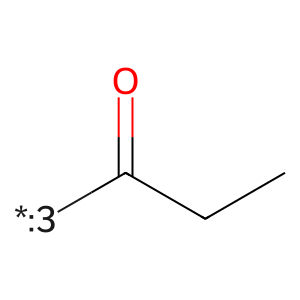
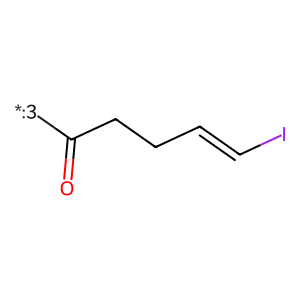
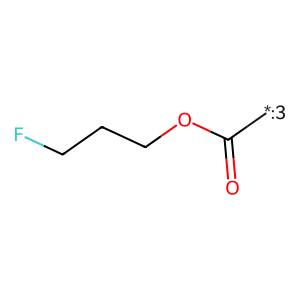
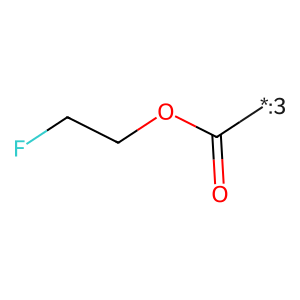
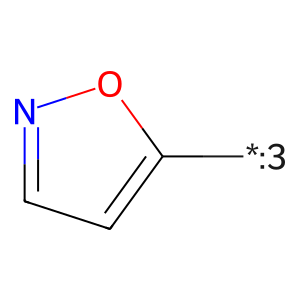
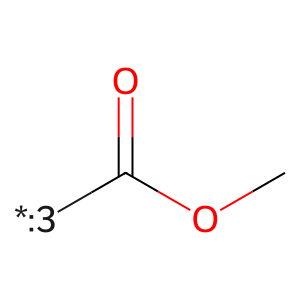
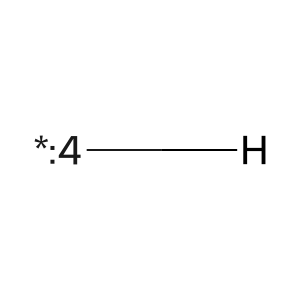
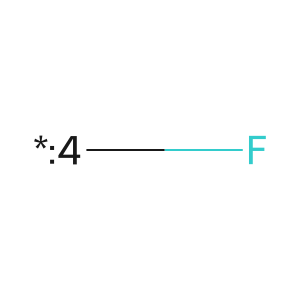
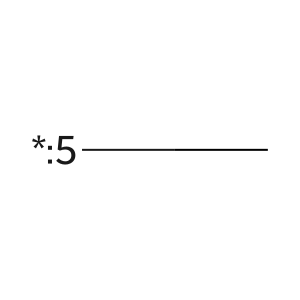
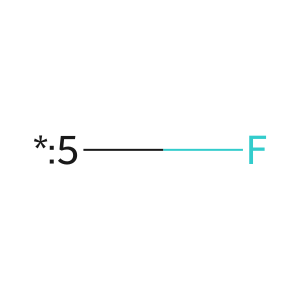
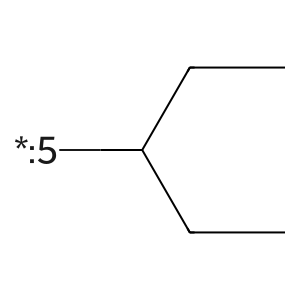
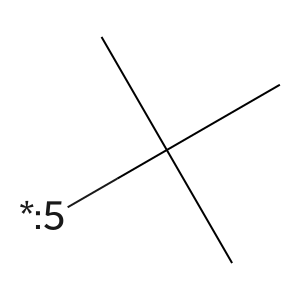
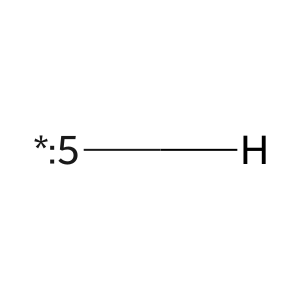
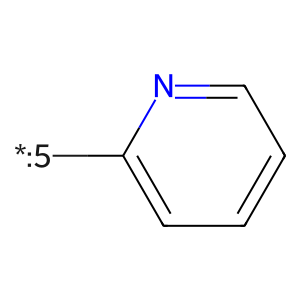
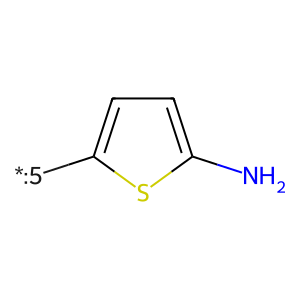
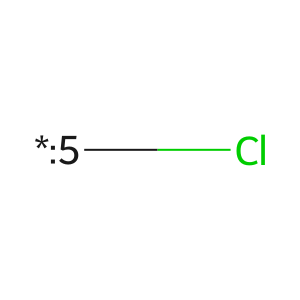
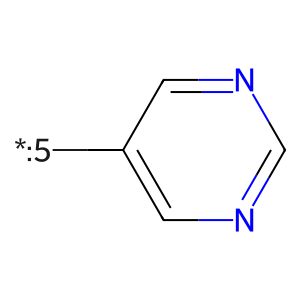
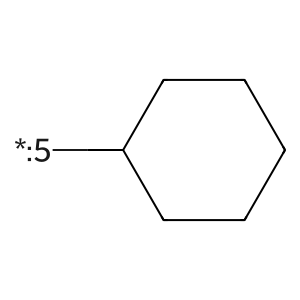
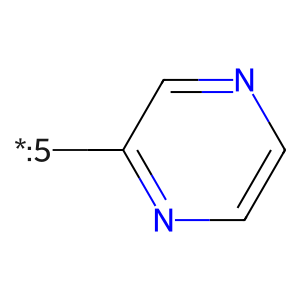
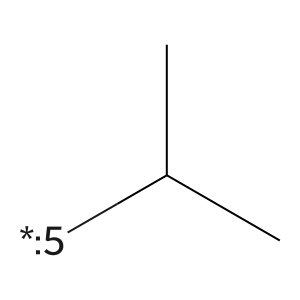
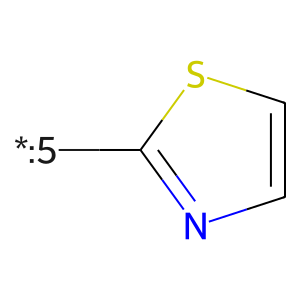
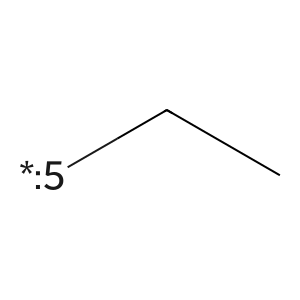
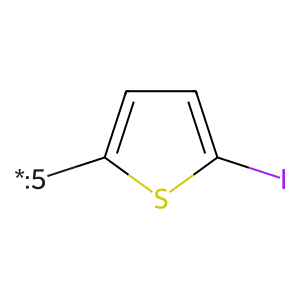
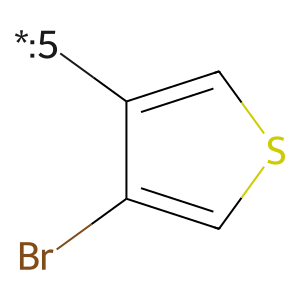
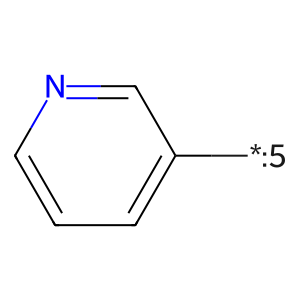
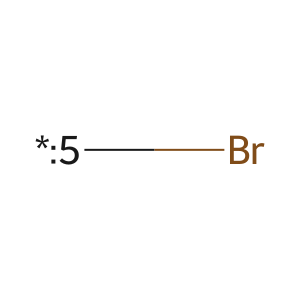
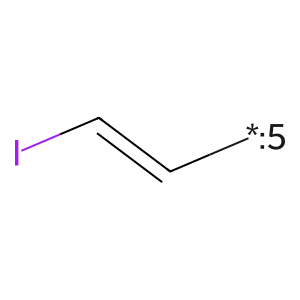
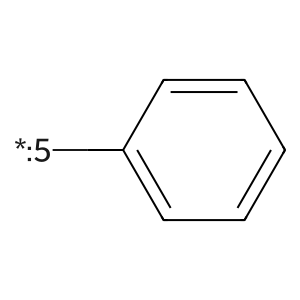
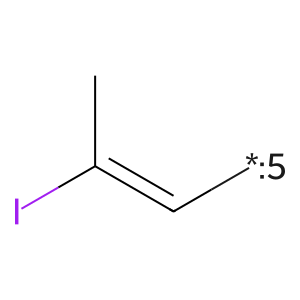
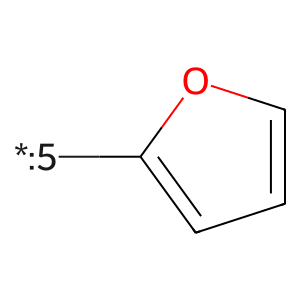
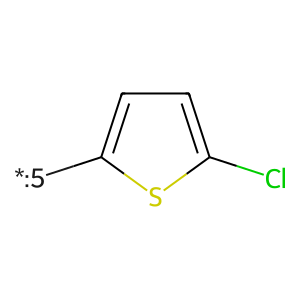
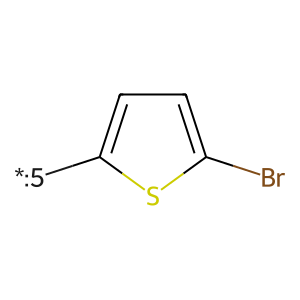
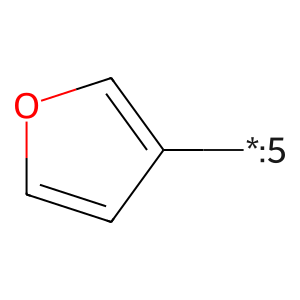
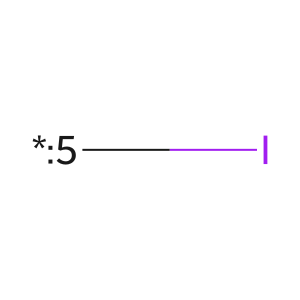
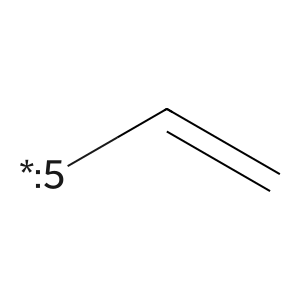
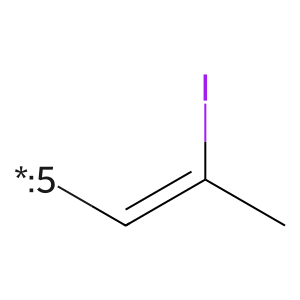
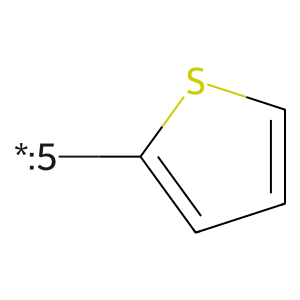
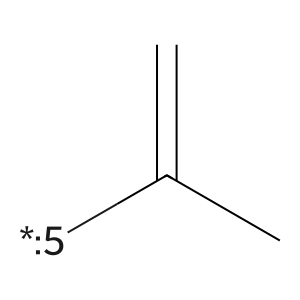
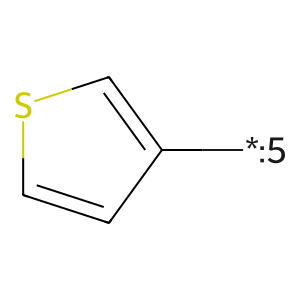

In [17]:
# Network Visualization (Regression Coefficients)
net = Network(height="1000px", width="1900px", notebook=True)
core_df2 = pd.DataFrame({"mol": [core_mol]})
core_image_base64 = generate_molecule_image(core_df2.iloc[0]["mol"])
net.add_node("Core", label="Core", title="Core", shape="circularImage",
             image=f"data:image/png;base64,{core_image_base64}", borderWidth=3, color="grey")

for r in rg_df_dict:
    net.add_node(r, label=r, title=r, color="grey")
    net.add_edge("Core", r, width=3, color="grey", label=r)
    for index, row in rg_df_dict[r].iterrows():
        node_id = f"{row['smiles']}"
        score = row['coef']
        score_string = str(round(score, 3))
        color = "green" if score > 0 else "red" if score < 0 else "grey"
        mol_img = generate_molecule_image(Chem.MolFromSmiles(row["smiles"]))
        net.add_node(node_id,
                     label=score_string,
                     title=node_id,
                     shape="circularImage",
                     image=f"data:image/png;base64,{mol_img}",
                     borderWidth=3,
                     color=color)
        net.add_edge(r, node_id, width=3, color=color)

# Save and display the network
net.show("free_wilson_coefficient_network.html")
display(HTML(open("free_wilson_coefficient_network.html").read()))

## Additional Network Visualization (Molecules by pIC50)

We build an interactive network of the original molecules. Each node is colored by its pIC50 value using the continuous viridis colormap, and a color bar is displayed.

Calculating pairwise similarities for molecules...
Number of edges in the molecule network: 223


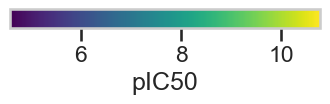

In [18]:
# Additional Network Visualization (Molecules by pIC50)
def get_fingerprint(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return fp
    except Exception as e:
        return None

fw_df['Fingerprint'] = fw_df.SMILES.apply(get_fingerprint)
fw_df = fw_df[fw_df['Fingerprint'].notnull()].reset_index(drop=True)

molecule_threshold = 0.7  # adjust as needed
mol_edges = []
fps = fw_df['Fingerprint'].tolist()
print("Calculating pairwise similarities for molecules...")
for i in range(len(fps)):
    for j in range(i + 1, len(fps)):
        sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        if sim > molecule_threshold:
            mol_edges.append((i, j, sim))
print(f"Number of edges in the molecule network: {len(mol_edges)}")

cmap_viridis = mpl.colormaps["viridis"]
norm = mcolors.Normalize(vmin=fw_df['pIC50'].min(), vmax=fw_df['pIC50'].max())

mol_net = Network(height="600px", width="1000px", notebook=True)
for idx, row in fw_df.iterrows():
    label = row['Name'] if 'Name' in fw_df.columns and pd.notnull(row['Name']) else str(row['SMILES'])
    pIC50_val = row['pIC50']
    rgba = cmap_viridis(norm(pIC50_val))
    hex_color = mcolors.to_hex(rgba)
    mol_net.add_node(idx, label=label,
                     title=f"SMILES: {row['SMILES']}<br>pIC50: {pIC50_val}",
                     color=hex_color, shape="circularImage")
for edge in mol_edges:
    mol_net.add_edge(edge[0], edge[1], value=edge[2])
mol_net.show_buttons(filter_=['physics'])
mol_net.save_graph("molecule_pIC50_network.html")

fig, ax = plt.subplots(figsize=(4, 0.5))
fig.subplots_adjust(bottom=0.5)
smap_obj = cm.ScalarMappable(norm=norm, cmap=cmap_viridis)
smap_obj.set_array([])
cbar = plt.colorbar(smap_obj, cax=ax, orientation='horizontal')
cbar.set_label('pIC50')
plt.show()

display(HTML(open("molecule_pIC50_network.html").read()))

## Molecule Networks Visualization (Separate CSV)

In this section, we load a separate CSV file (replace the file path as needed), compute molecular fingerprints, and build an interactive network based on pairwise Tanimoto similarities. Nodes are colored by pIC50.

In [20]:
# Load a separate CSV file for molecule networks
df = pd.read_csv("data/CHEMBL313_sel.smi")  # Replace with your CSV file path

def get_fingerprint(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
        return fp
    except Exception as e:
        return None

df['Fingerprint'] = df['SMILES'].apply(get_fingerprint)
df = df[df['Fingerprint'].notnull()].reset_index(drop=True)

similarity_threshold = 0.7  # adjust as needed
edges = []
fps = df['Fingerprint'].tolist()

print("Calculating pairwise similarities...")
for i in range(len(fps)):
    for j in range(i + 1, len(fps)):
        sim = DataStructs.TanimotoSimilarity(fps[i], fps[j])
        if sim > similarity_threshold:
            edges.append((i, j, sim))
print(f"Number of edges in the network: {len(edges)}")

norm = mcolors.Normalize(vmin=df['pIC50'].min(), vmax=df['pIC50'].max())
cmap_viridis = mpl.colormaps["viridis"]

nt = Network(height="600px", width="1000px", notebook=True)
for idx, row in df.iterrows():
    label = row['Name'] if 'Name' in df.columns and pd.notnull(row['Name']) else str(row['SMILES'])
    pIC50_val = row['pIC50']
    rgba = cmap_viridis(norm(pIC50_val))
    hex_color = mcolors.to_hex(rgba)
    nt.add_node(idx, label=label, 
                title=f"SMILES: {row['SMILES']}<br>pIC50: {pIC50_val}",
                color=hex_color, shape="circularImage")
for edge in edges:
    nt.add_edge(edge[0], edge[1], value=edge[2])
nt.show_buttons(filter_=['physics'])
nt.save_graph("molecule_network.html")

display(HTML(open("molecule_network.html").read()))

Calculating pairwise similarities...
Number of edges in the network: 223
